# Detecting Anomalies in Time Series 

In [1]:
import sys
import os

from os.path import join, dirname
import pandas as pd
import math
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import copy

PATH_REPO = dirname(os.getcwd())
PATH_DATA = join(PATH_REPO, 'data')
PATH_UTILS = join(PATH_REPO, 'src')

sys.path.append(PATH_UTILS)

import utils_plot


## 1. Class Time Series

### 1.1 Characteristics needed time series

**Trend:**

1. using mean: 
$$\hat{y}_i: \frac{1}{w} \sum^{w}_{k=1}y_{i-k}$$

2. using median:
$$\hat{y}_i: median(y_{i-w}, y_{i-w+1}, ..., y_{i-1})$$

**Standard deviation:**

$$\sigma_i: \sqrt{\frac{1}{w}\sum^{w}_{k=1}(y_{i-k} - \hat{y}_i)^2}$$



### 1.2 Calculate Prediction intervals

The confidence intervals are calculated using the median and the standard deviation. The median is used instead of the mean because the median is more robust to outliers. The standard deviation is used to calculate the confidence intervals because the standard deviation is a measure of how spread out the data is from the mean. The confidence intervals are calculated using the following formula:

$$LowerBound_{day_i} = median_{window_i} - 1.96 * std_{window_i}$$

$$UpperBound_{day_i} = median_{window_i} + 1.96 * std_{window_i}$$

Where $window_i$ is the window of data from day $i-1$ to day $i - (window\_size + 1)$.


In [2]:
class timeSeries:
    """
    A class to represent a Time Series and to calculate some typical properties of 
    Time series
    """

    WINDOW_SIZE_STD = 20  
    WINDOW_SIZE_MEAN = 20

    def __init__(self, ts:np.array, dates:np.array):
        """
        Initializes the time series with raw time data values and its corresponding dates
        Args:
            - ts, numpy array: the time series values
            - dates, numpy array: the corresponding dates
        """
        
        self.time_series = pd.Series(ts, index=pd.to_datetime(dates))

        self.trend = None
        self.std = None

        self.lower_bound = None
        self.upper_bound = None
    
    def compute_trend(self, window):
        """
        Computes the trend of the time series
        """
        self.trend = self.time_series.rolling(window=window, closed='left').mean()
    
    def compute_std(self, window):
        """
        Computes the standard deviation of the time series
        """
        self.std = self.time_series.rolling(window=window, closed='left').std()

    def prediction_interval(self, window, multiplier=1.96):
        """
        Calculates the confidence intervals for the time series or the anomaly adjusted time series.
        
        Args:
        anomaly (bool): If True, compute confidence intervals for the anomaly adjusted time series.
        """

        if self.trend is None:
            self.compute_trend(window)
        
        if self.std is None:
            self.compute_std(window)

        self.lower_bound = self.trend - (multiplier * self.std)
        self.upper_bound = self.trend + (multiplier * self.std)


## 2. Detecting Anomalies

For this iteration, we will implement a similar methodology to [Anomaly detection in univariate time series incorporating active learning](https://www.sciencedirect.com/science/article/pii/S2772415822000323) but using the parametric methodology.

### 2.1 Class Anomaly TS

The class anomaly time series inherits from the class Time Series. This class is meant to create time series instances where we desired to detect anomalies.

### 2.2 Detecting Anomalies

Our algorithm $\mathcal{A}$ detects the anomalies of a given time series T and a set of hyperparameters $\lambda$ as follows:

1. For a given day i we observe our time series value $v_i$ and compare it to the prediction interval. If $v_i$ is outside the prediction interval, we flag it as an anomaly. We have a vector $z$ that has boolean values and tells you wether the index i is an anomaly or not.

$$
\begin{cases}
v_i > \hat{v_i} + Multiplier \times \hat{\sigma}_i & \text{ then } z_i == 1 \\
v_i \leq \hat{v_i} + Multiplier \times \hat{\sigma}_i & \text{then } z_i == 0 \\
\end{cases}
$$

2. Anomalies have an influence on the MA and the PI for the next  data points. We introduced an hyperparameter to control the influence of classified outliers, $a \in [0,1]$. Each classified anomaly point $v_i$ is transform into $v^*_i$


 $$
 v^*_i = 
\begin{cases}
v_i + a\times z_i \times (\hat{v}_i - v_i) \text{ when } v_i<\hat{v}_i \\
v_i - a\times z_i \times (\hat{v}_i - v_i) \text{ when } v_i>\hat{v}_i\\
\end{cases}
$$



In [3]:
class algorithmAnomalyTimeSeries():
    """
        A subclass of Time Series more focused on the anomaly properties of the time series
    """
    def __init__(self, window:int, absolute_threshold:float=10, a:float=0.5, multiplier:float=1.96):

        #hyperparameters Algorithm
        self.threshold = absolute_threshold
        self.a = a
        self.multiplier = multiplier
        self.window = window

    def detect_alerts(self, time_series:timeSeries):
        """
        Method to detect the alerts of the whole time series!
        """
        
        modified_time_series = copy.deepcopy(time_series)
        alerts_idx = []
        alerts = pd.Series([np.nan]*len(time_series.time_series), index=time_series.time_series.index)
        threshold = max(self.threshold, time_series.time_series.median())


        for i in range(len(modified_time_series.time_series)):

            # FIRST PART: Compute the upper bound & lower bound
            modified_time_series.compute_trend(self.window)
            modified_time_series.compute_std(self.window)

            ### Let's check the confidence intervals are available
            if i == 0 or math.isnan(modified_time_series.trend[i]):
                continue

            upper_bound = modified_time_series.trend + (self.multiplier * modified_time_series.std)
            lower_bound = modified_time_series.trend - (self.multiplier * modified_time_series.std)

            #SECOND PART: Detect the alert

            if modified_time_series.time_series[i] > upper_bound[i] \
                  and modified_time_series.time_series[i] > threshold:
            
                # THIRD PART: Store the alert
                alerts_idx.append(i)
                alerts[i] = time_series.time_series[i]

                # FOURTH PART a): UPDATE the time series
                modified_time_series.time_series[i] = modified_time_series.time_series[i] - self.a*(modified_time_series.time_series[i] - upper_bound[i])


            if modified_time_series.time_series[i] < lower_bound[i]:

                # FOURTH PART b) : UPDATE the time series
                modified_time_series.time_series[i] = modified_time_series.time_series[i] + self.a*(lower_bound[i] - modified_time_series.time_series[i])
            


        return {'alerts':alerts, 'alerts_idx':alerts_idx, 'modified_time_series':modified_time_series, 'original_time_series':time_series}
    


# 3. Experiments with Simulated data

### 3.1 Let's fix the random seed

In [4]:
import random
random.seed(42)

### 3.2 First Experiment: Sinusoidal time series

Let's simulate a sinusoidal time series with a period of 1 day and a frequency of 1/7.

The time series below has no anomalies since the pattern is consistent. Therefore we should not see any anomalies detected.


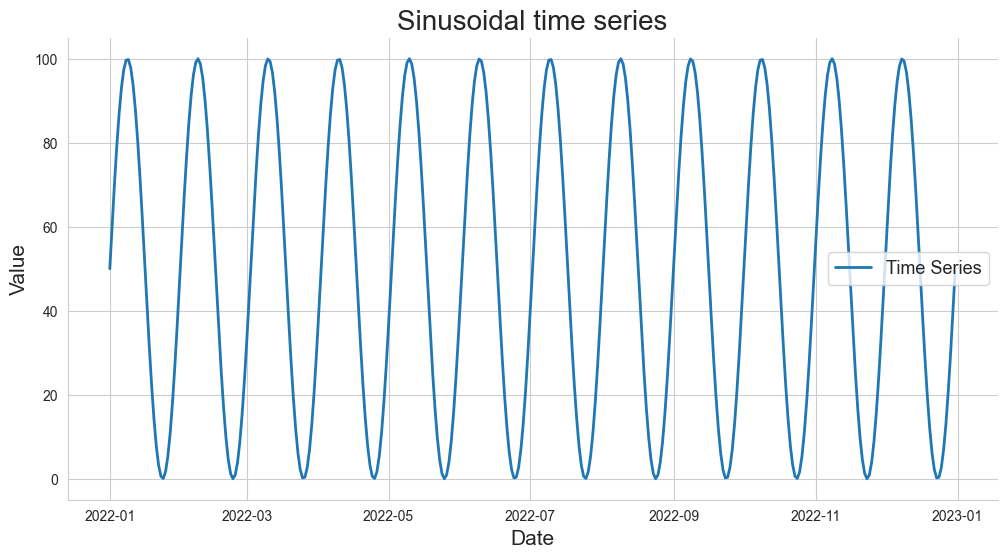

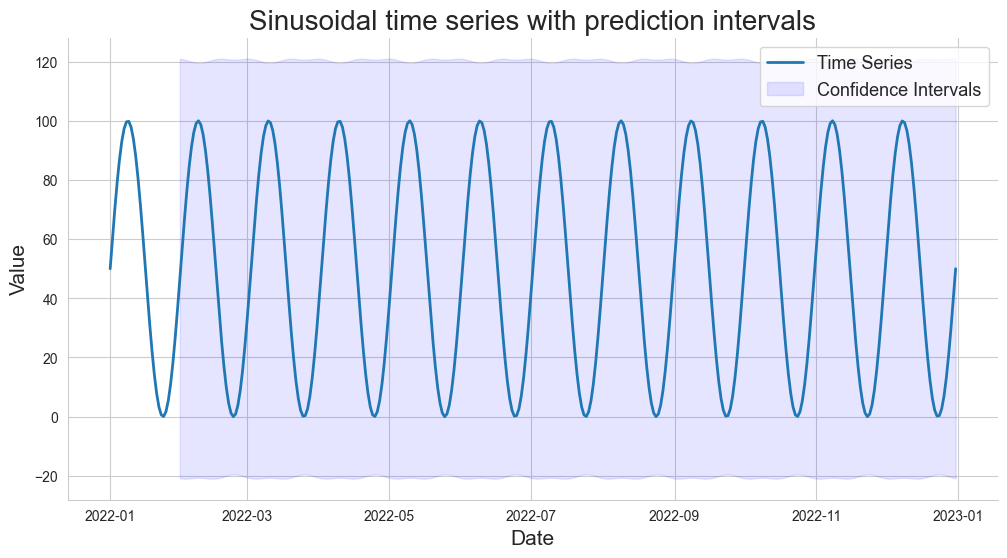

In [5]:
import math

# (Given class definitions are assumed to be here)

# 1. Generate a synthetic time series

# Basic sine wave
np.random.seed(0) # for reproducibility
dates = pd.date_range(start="2022-01-01", periods=365, freq='D')
time_series_values = np.sin(np.linspace(0, 24 * np.pi, 365)) * 50 + 50


# 2. Use the classes
ts = timeSeries(time_series_values, dates)
# 3. Visualize the results

utils_plot.plot_time_series(ts, label='Sinusoidal time series')

utils_plot.plot_time_series(ts, prediction_intervals=True, label='Sinusoidal time series with prediction intervals')


Let's now run the anomaly detection algorithm it should not detect anomalies

In [6]:
anomaly_detection = algorithmAnomalyTimeSeries(window=30, absolute_threshold=10, a=0.5)
results = anomaly_detection.detect_alerts(ts)


print(f'We foung {len(results["alerts_idx"])} anomalies in the time series.')

We foung 0 anomalies in the time series.


### 3.2 Second Experiment: Sinusoidal time series with noise and Anomalies


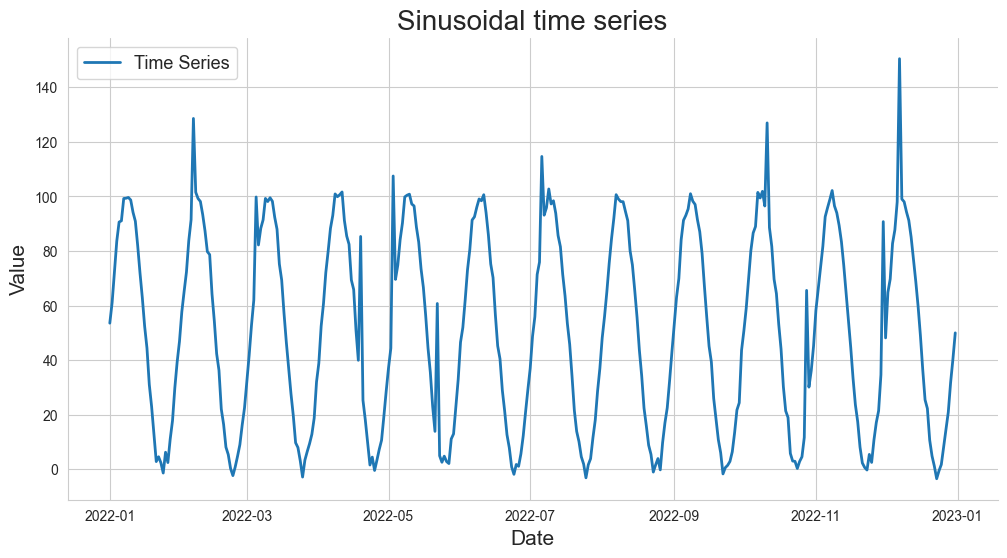

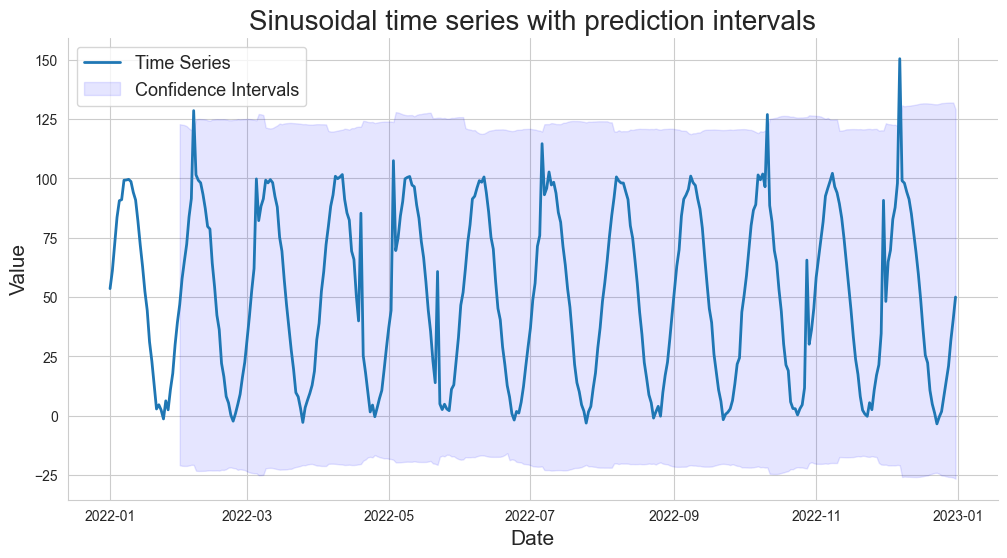

In [7]:
import math

# (Given class definitions are assumed to be here)

# 1. Generate a synthetic time series

# Basic sine wave
np.random.seed(0) # for reproducibility
dates = pd.date_range(start="2022-01-01", periods=365, freq='D')
time_series_values = np.sin(np.linspace(0, 24 * np.pi, 365)) * 50 + 50

# Adding some noise
time_series_values += np.random.normal(0, 2, 365)

# Introduce a few anomalies
anomalies = np.random.choice(np.arange(365), size=10, replace=False)
time_series_values[anomalies] += np.random.choice([50, 30], size=10)

# 2. Use the classes
ts = timeSeries(time_series_values, dates)
# 3. Visualize the results

utils_plot.plot_time_series(ts, label='Sinusoidal time series')

utils_plot.plot_time_series(ts, prediction_intervals=True, label='Sinusoidal time series with prediction intervals')


We found 3 anomalies in the time series.


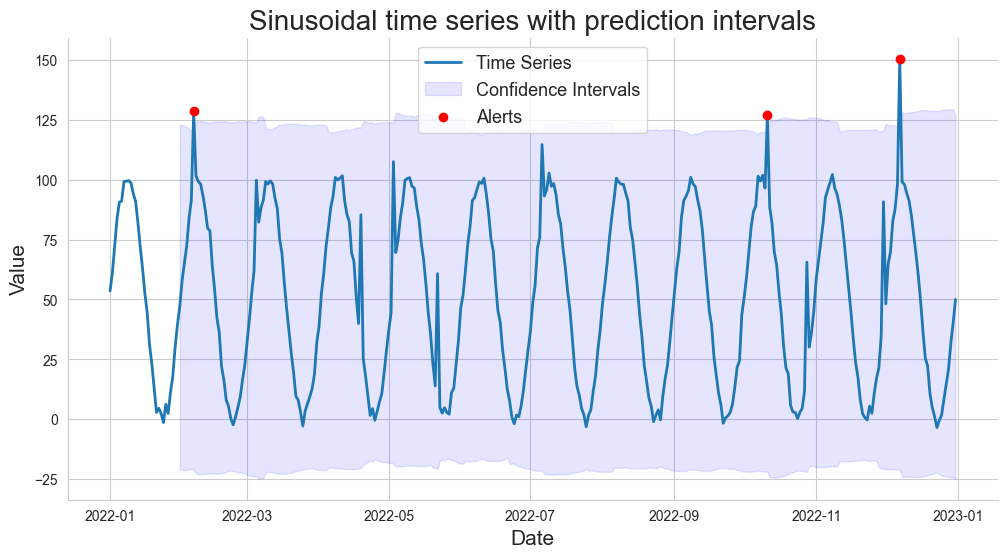

In [9]:
anomaly_detection = algorithmAnomalyTimeSeries(window=30, absolute_threshold=10, a=0.5)
results = anomaly_detection.detect_alerts(ts)


print(f'We found {len(results["alerts_idx"])} anomalies in the time series.')

utils_plot.plot_time_series_alerts(time_series_original=ts,time_series_modified= results['modified_time_series'], alerts=results['alerts'],prediction_intervals=True, label='Sinusoidal time series with prediction intervals')

### 3.3 Third experiment: Varying the Window

#### 3.3.1 Window size=10

We found 40 anomalies in the time series.


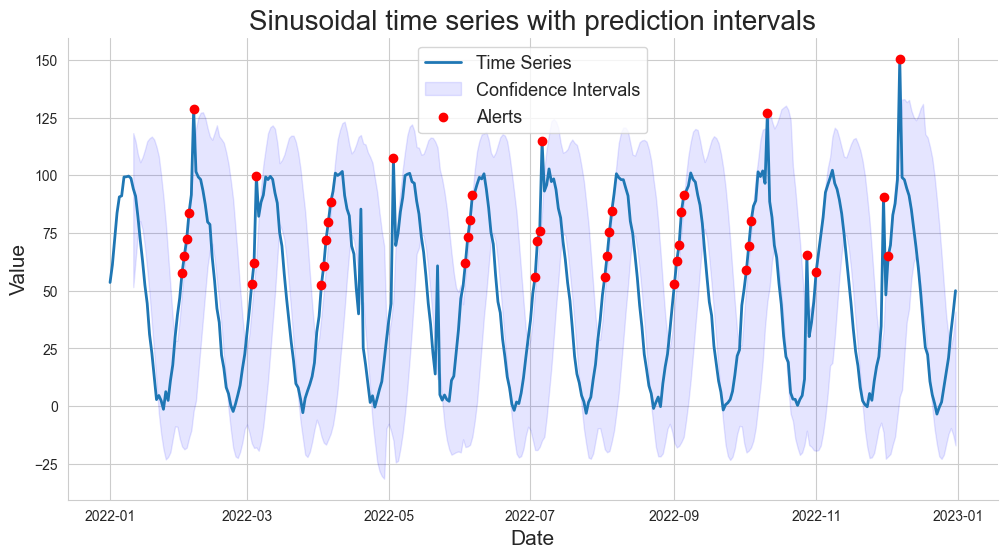

In [11]:
anomaly_detection = algorithmAnomalyTimeSeries(window=10, absolute_threshold=10, a=0.5)
results = anomaly_detection.detect_alerts(ts)


print(f'We found {len(results["alerts_idx"])} anomalies in the time series.')

utils_plot.plot_time_series_alerts(time_series_original=ts,time_series_modified= results['modified_time_series'], alerts=results['alerts'],prediction_intervals=True, window=10, label='Sinusoidal time series with prediction intervals')

### 3.3.2 Window size=20

We found 45 anomalies in the time series.


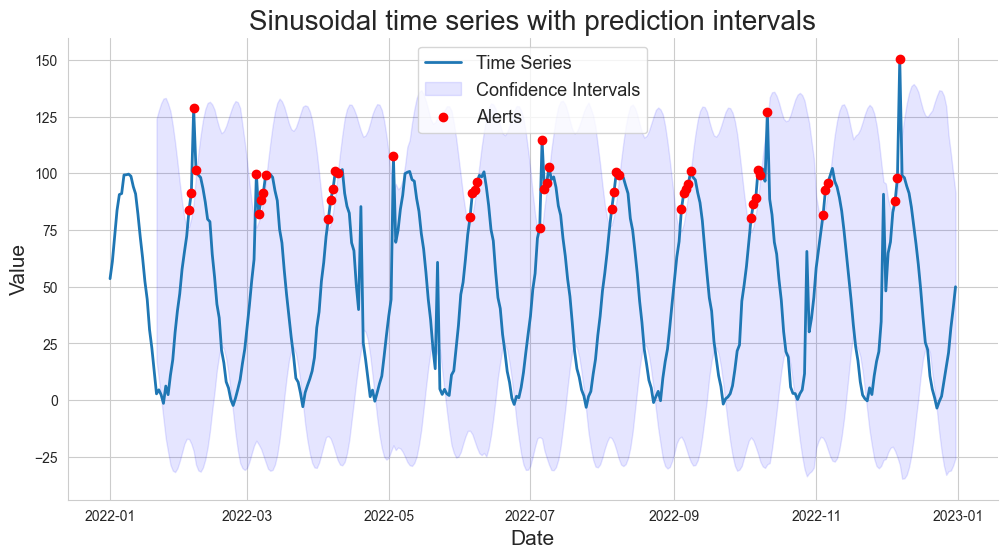

In [12]:
window_=20
anomaly_detection = algorithmAnomalyTimeSeries(window=window_, absolute_threshold=10, a=0.5)
results = anomaly_detection.detect_alerts(ts)


print(f'We found {len(results["alerts_idx"])} anomalies in the time series.')

utils_plot.plot_time_series_alerts(time_series_original=ts,time_series_modified= results['modified_time_series'], alerts=results['alerts'],prediction_intervals=True, window=window_, label='Sinusoidal time series with prediction intervals')